# Sentiment Analysis 

- Sentiment Analysis: e.g. Loughran and McDonald (2011) sentiment word list
- SEC Edgar 10-K Company Filings: e.g. Cohen, Malloy and Nguyen (2020), 


In [1]:
import re
import requests
import time
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import sklearn.feature_extraction
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from finds.database.sql import SQL
from finds.database.redisdb import RedisDB
from finds.database.mongodb import MongoDB
from finds.structured.crsp import CRSP
from finds.structured.signals import Signals
from finds.unstructured import Unstructured
from finds.unstructured.store import Store
from finds.busday import BusDay
from finds.filters import weighted_average
from finds.backtesting import fractiles
from finds.readers.edgar import Edgar
from finds.readers.alfred import Alfred
from finds.misc.show import Show
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 0
show = Show(ndigits=4, latex=None)

In [2]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
bd = BusDay(sql)
rdb = RedisDB(**credentials['redis'])
crsp = CRSP(sql, bd, rdb, verbose=VERBOSE)
ed = Edgar(paths['10X'], zipped=True, verbose=VERBOSE)
signals = Signals(user)
mongodb = MongoDB(**credentials['mongodb'], verbose=VERBOSE)
wordlists = Unstructured(mongodb, 'WordLists')
store = Store(paths['scratch'], ext='pkl')
imgdir = paths['images'] / 'edgar'
item, form = 'mda10K', '10-K'

def _print(*args, **kwargs):
    """print messages if VERBOSE"""
    if VERBOSE:
        print(*args, **kwargs)

Last FamaFrench Date 2023-06-30 00:00:00


## Loughran and MacDonald dictionaries

In [3]:
# Load Loughran and MacDonald sentiment words and stopwords
wordlists = Unstructured(mongodb, 'WordLists')
sentiments = {sent: wordlists['lm', sent] for sent in ['positive', 'negative']}

In [4]:
# Pre-process with sklearn methods
tf_vectorizer = CountVectorizer(
    strip_accents='unicode',
    lowercase=True,
    #stop_words=stop_words,
    # tokenizer=CustomTokenizer(),
    token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b")
analyzer = tf_vectorizer.build_analyzer()

In [5]:
# Construct sentiment feature all years for usual universe
univs = {yr+1: crsp.get_universe(bd.endmo(yr*10000 + 1231)).assign(year=yr+1)
         for yr in range(1992, 2020)}
rows = DataFrame(ed.open(form=form, item=item))  # open mda10K archive
permnos = rows['permno'].unique().astype(int)

tic = time.time()
results = []
for i, permno in tqdm(enumerate(permnos)):  # Loop over all permnos
    
    # retrieve all valid mda's for this permno by year
    mdas = {}
    dates = {}
    files = rows[rows['permno'].eq(permno)].to_dict('records')
    for i, f in enumerate(files):
        year = int(f['date']) // 10000
        if ((f['date'] // 100) % 100) <= 3:  # if filing date <= Mar
            year = year - 1                  # then assign to previous year
        if (year in univs and
            (year not in mdas or f['date'] < dates[year])):
            tokens = Series(analyzer(ed[f['pathname']]), dtype='object')
            if len(tokens):
                mdas[year] = tokens
                dates[year] = f['date']

    # compute sentiment (count frequency) scores for permno by year
    sentiment = {year: (mda.isin(sentiments['positive']).sum()
                        - mda.isin(sentiments['negative']).sum()) / len(mda)
                 for year, mda in mdas.items()}  # compute sentiment by year

    # derive sentiment change and similarity scores by year
    for year in sorted(mdas.keys()):
        result = {'year': year, 'permno': permno, 'date': dates[year]}
        result['mdasent'] = sentiment[year]
        result['currlen'] = len(mdas[year])
        if year-1 in mdas:
            result['prevlen'] = len(mdas[year-1])
            result['mdachg'] = sentiment[year] - sentiment[year-1]
            
            corpus = [" ".join(mdas[year]), " ".join(mdas[year-1])]
            cos = cosine_similarity(tf_vectorizer.fit_transform(corpus))
            result['mdacos'] = cos[0, 1]
            _print(i, int(time.time()-tic), result)
        results.append(result)

12632it [21:08,  9.96it/s]


In [6]:
# save in signals database
data = DataFrame.from_records(results)
data['rebaldate'] = bd.offset(data['date'])
print(signals.write(data, 'mdasent', overwrite=True),
      signals.write(data, 'mdachg', overwrite=True),
      signals.write(data, 'mdacos', overwrite=True))

(signals_write) mdasent 107105
(signals_write) mdachg 88292
(signals_write) mdacos 88292
107105 88292 88292


In [7]:
# right join data with univ, to identify univ with missing mda
data = pd.concat([data[data['year']==year]\
                  .drop(columns=['year'])\
                  .set_index('permno')\
                  .join(univ[['year']], how='right')\
                  .reset_index()
                  for year, univ in univs.items() if year <= 2020],
                 ignore_index=True)

In [11]:
# save sentiment dataframe in scratch folder
store.dump(data, 'sentiment')
data = store.load('sentiment')

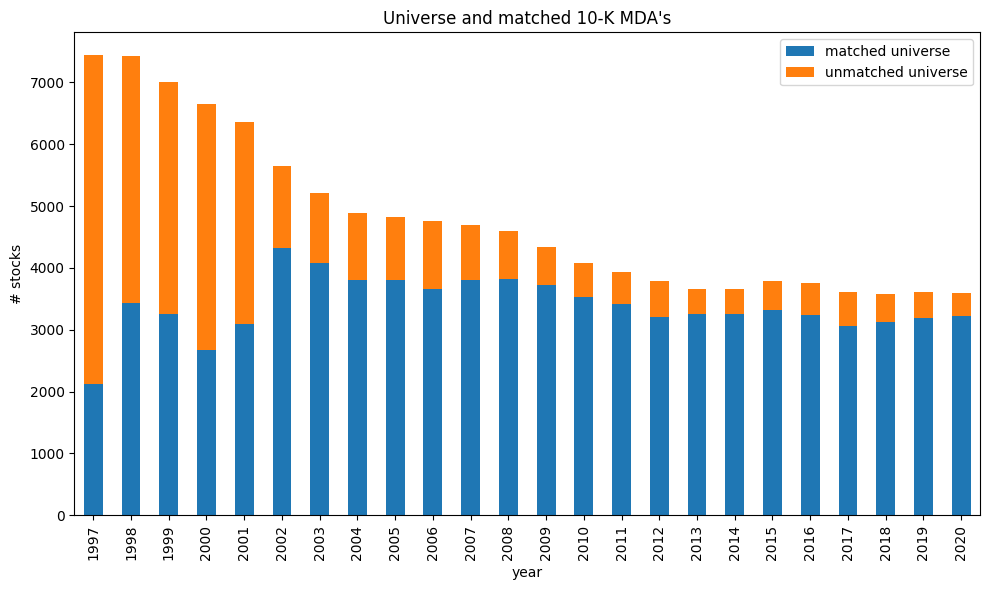

In [12]:
# Stacked Bar Plot of universe coverage by year
y1 = data[data['mdasent'].notna()]\
    .groupby('year')['permno']\
    .count()
y0 = data[data['mdasent'].isna()]\
    .groupby('year')['permno']\
    .count()\
    .reindex(y1.index)
fig, ax = plt.subplots(1, 1, clear=True, num=1, figsize=(10, 6))
y1.plot(kind='bar',
        label='matched universe',
        color='C0',
        ax=ax,
        rot=90)
y0.plot(kind='bar',
        label='unmatched universe',
        color='C1',
        ax=ax,
        rot=90,
        bottom=y1)
ax.set_ylabel('# stocks')
ax.set_title("Universe and matched 10-K MDA's")
ax.legend()
plt.tight_layout()
plt.savefig(imgdir / 'coverage.jpg')

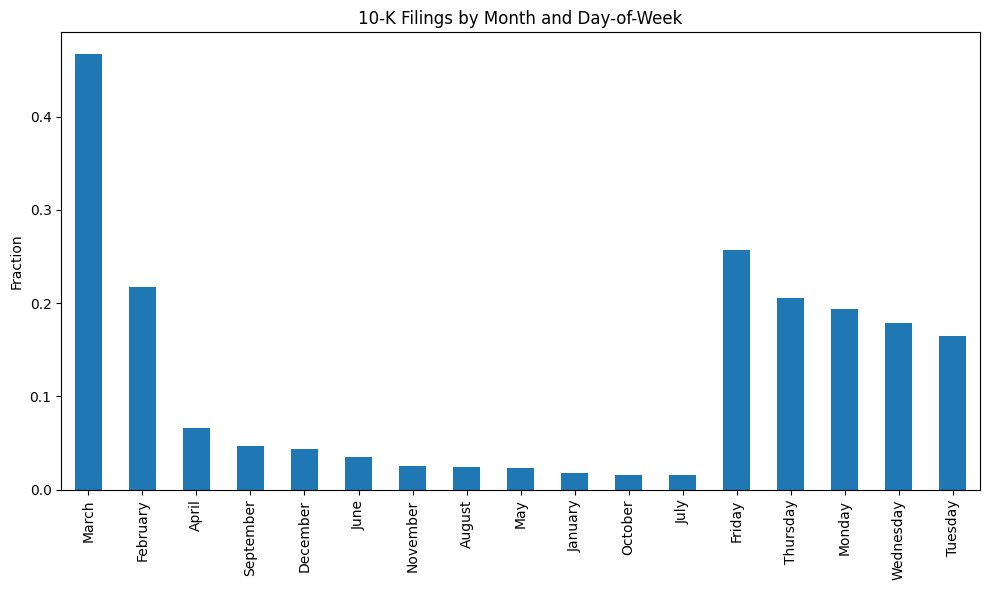

In [14]:
# Stacked Bar Plot of filings date, by month and day-of-week
y = DataFrame.from_records([{'date': int(d),
                             'day': bd.datetime(int(d)).strftime('%A'),
                             'month': bd.datetime(int(d)).strftime('%B')}
                            for d in data.loc[data['mdasent'].notna(), 'date']])
z = pd.concat([y['month'].value_counts()/len(y),
               y['day'].value_counts()/len(y)])
fig, ax = plt.subplots(1, 1, clear=True, num=1, figsize=(10, 6))
z.plot(kind='bar',
       color='C0',
       ax=ax,
       rot=90)
ax.set_ylabel('Fraction')
ax.set_title("10-K Filings by Month and Day-of-Week")
plt.tight_layout()
plt.savefig(imgdir / 'calendar.jpg')

__Plot distributions of sentiment, change, similarity univ by year__

- visualize with economy-wide profitabality (CP Corporate Profits from FRED)
Align year as caldate, e.g. for caldate year 2019:
- filings from April 2019 to Mar 2020 (i.e. year = filing year-1 if month<=3)
- universe is as of year end prior to filing date
- economic time series is average annual value ending Dec 2019
- concurrent return year is Jan 2019 to Dec 2019
- next return year (i.e. lagged filings) is April 2020-Mar 2021
#data = data.dropna(subset=['date'])

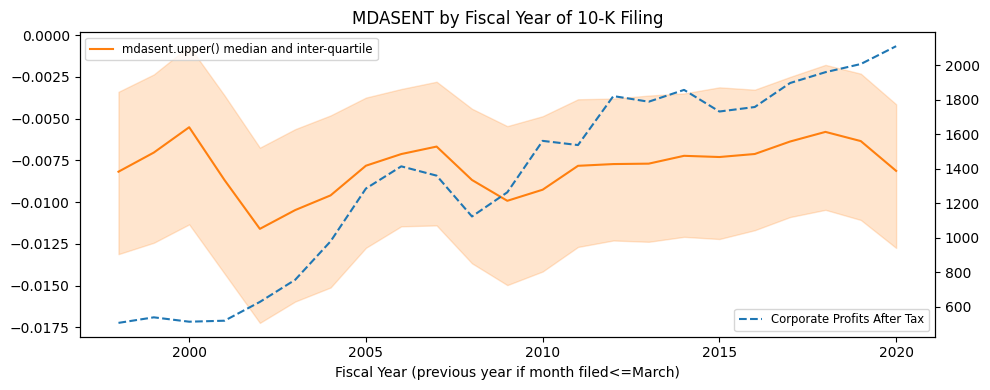

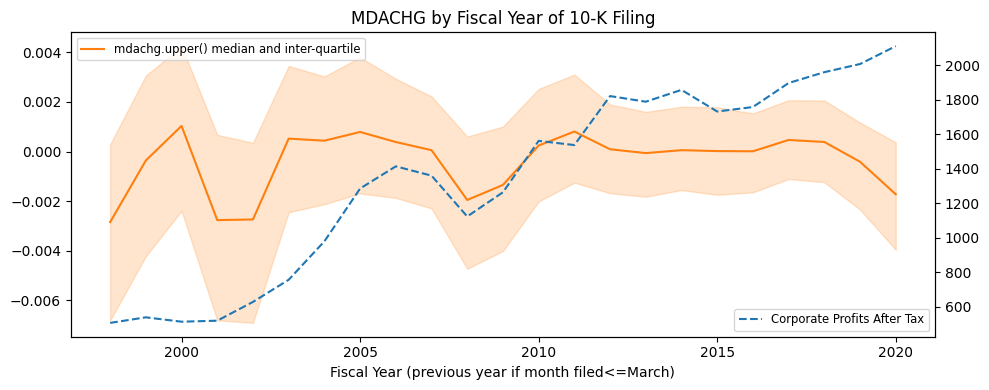

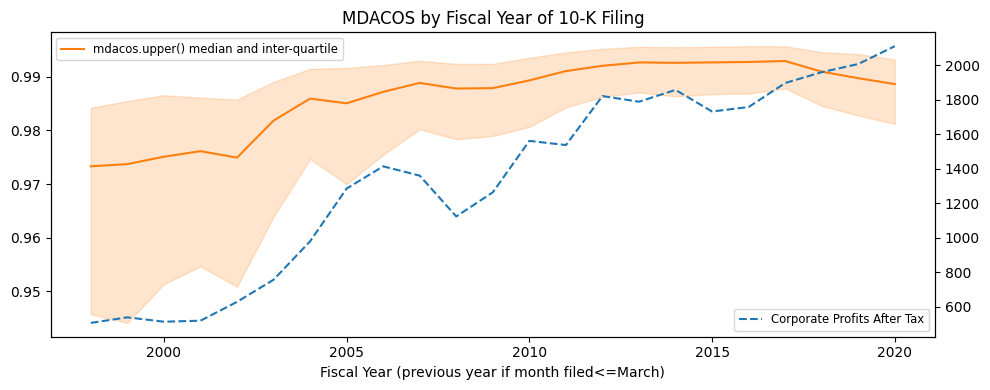

In [15]:
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)
series_id = 'CP'  # Corporate Profits
#series_id = 'UNRATE'
#series_id = 'WILL5000IND'
econ = alf(series_id)
econ = econ.to_frame()\
           .assign(year=econ.index // 10000)\
           .groupby('year')\
           .mean()
           
for i, sent in enumerate(['mdasent', 'mdachg', 'mdacos']):
    g = data[data['currlen'].gt(500)].dropna().groupby('year')
    iq1, iq2, iq3 = [g[sent].quantile(p) for p in [.25, .5, .75]]
    y = iq2.index.astype(int)
    fig, ax = plt.subplots(1, 1, clear=True, num=1+i, figsize=(10, 4))
    ax.plot(y, iq2, ls='-', color='C1')
    ax.fill_between(y, iq1, iq3, alpha=0.2, color='C1')
    ax.set_title(f"{sent.upper()} by Fiscal Year of 10-K Filing")
    ax.set_xlabel("Fiscal Year (previous year if month filed<=March)")
    ax.legend([f"{sent}.upper() median and inter-quartile"],
              fontsize='small',
              loc='upper left')
    #econ.index = ax.get_xticks()   # boxplot(by) has sequential xticks
    bx = ax.twinx()
    econ[(econ.index >= min(y)) & (econ.index <= max(y))]\
        .plot(ls='--', ax=bx)
    bx.legend([alf.header(series_id)[:27]],
              fontsize='small',
              loc='lower right')
    plt.tight_layout()
    plt.savefig(imgdir / f'{sent}.jpg')

__Quintile cap-weighted spread portfolio weights__

- same year filings [yr]0101:[yr]1231 = bd.begyr(caldate) to caldate
- lagged [yr+1]0401:[yr+2]0331 = bd.begmo(caldate,4) - bd.endmo(caldate,15)


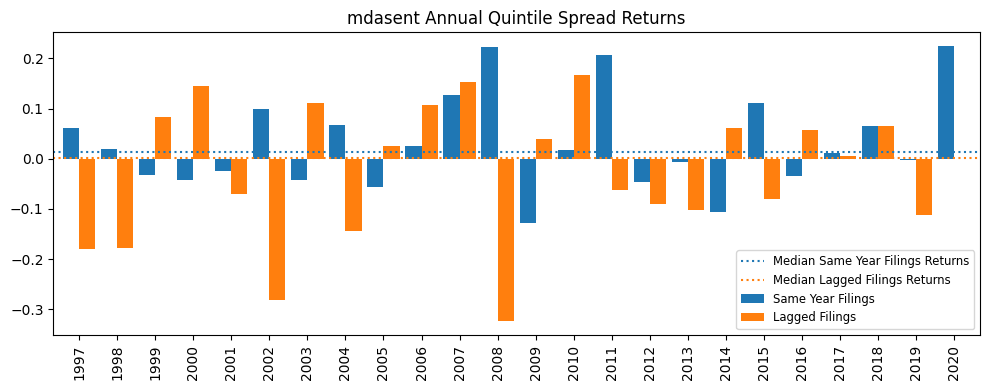

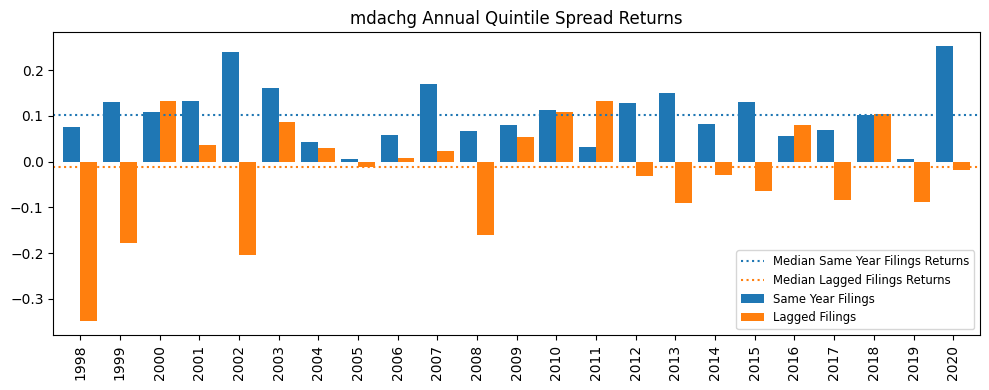

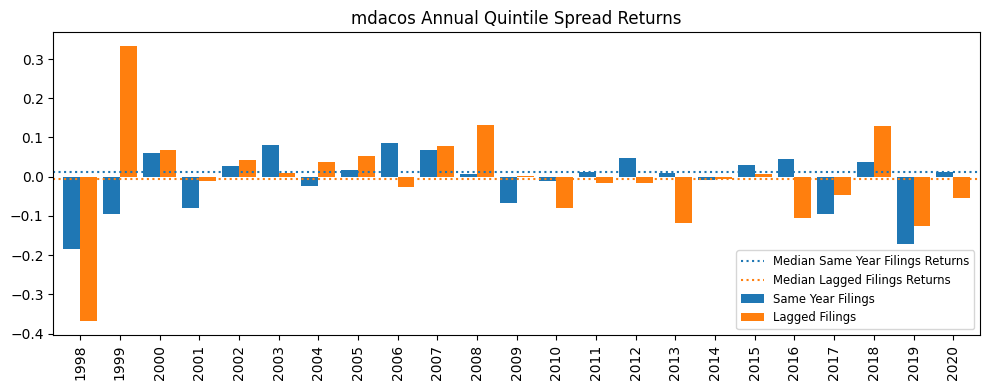

In [16]:
for ifig, key in enumerate(['mdasent', 'mdachg', 'mdacos']):
    ret1 = {}   # to collect year-ahead spread returns
    ret0 = {}   # to collect current-year spread returns
    for year in sorted(np.unique(data['year'])):  # loop over years
        
        # compute current year spread returns
        beg = bd.begyr(year)
        end = bd.endyr(year)
        univ = data[data['year'] == year]\
                   .dropna(subset=[key])\
                   .set_index('permno')\
                   .join(crsp.get_cap(bd.offset(beg, -1)), how='inner')\
                   .join(crsp.get_ret(beg, end, delist=True), how='left')
        if len(univ):
            sub = fractiles(univ[key], [20, 80])
            pos = weighted_average(univ.loc[sub==1, ['cap', 'ret']],
                                   'cap')['ret']
            neg = weighted_average(univ.loc[sub==3, ['cap', 'ret']],
                                   'cap')['ret']
            ret0[end] = {'ret': pos - neg,
                         'npos': sum(sub==1),
                         'nneg': sum(sub==3)}
            _print(end, len(univ), pos, neg)
            
        # compute year ahead spread returns
        beg = bd.begmo(end, 4)
        end = bd.endmo(end, 15)
        univ = data[data['year'] == year]\
                   .dropna(subset=[key])\
                   .set_index('permno')\
                   .join(crsp.get_cap(bd.offset(beg, -1)), how='inner')\
                   .join(crsp.get_ret(beg, end, delist=True), how='left')
        if len(univ):
            sub = fractiles(univ[key], [20, 80])
            pos = weighted_average(univ.loc[sub==1, ['cap', 'ret']],
                                   'cap')['ret']
            neg = weighted_average(univ.loc[sub==3, ['cap', 'ret']],
                                   'cap')['ret']
            ret1[end] = {'ret': pos - neg,
                         'npos': sum(sub==1),
                         'nneg': sum(sub==3)}
            _print(end, len(univ), pos, neg)

    r0 = DataFrame.from_dict(ret0, orient='index').sort_index()
    r0.index = r0.index // 10000
    r1 = DataFrame.from_dict(ret1, orient='index').sort_index()
    r1.index = (r1.index // 10000) - 2

    fig, ax = plt.subplots(1, 1, clear=True, num=1+ifig, figsize=(10, 4))
    pd.concat([r0['ret'].rename('Same Year Filings').to_frame(),
               r1['ret'].rename('Lagged Filings').to_frame()],
              join='outer',
              axis=1).plot(kind='bar',
                           ax=ax,
                           width=.85)
    ax.set_title(f"{key} Annual Quintile Spread Returns")
    ax.axhline(r0['ret'].median(), linestyle=':', color='C0',
               label='Median Same Year Filings Returns')
    ax.axhline(r1['ret'].median(), linestyle=':', color='C1',
               label='Median Lagged Filings Returns')
#    ax.legend(['Median Same Year Filings Returns',
#               'Median Lagged Filings Returns',
#               'Same Year Filings Returns',
#               'Lagged Filings Returns'],
    ax.legend(fontsize='small',
              loc='lower right')
    plt.tight_layout()
    plt.savefig(imgdir / f'{key}RET.jpg')